## TP 3.1 : Jeu de la minorité avec nombre variable d’agents

*Notebook fait par Alexandre Boistard, Ethan Trentin.*

In [208]:
import numpy as np
import matplotlib.pyplot as plt

Le modèle le plus simple est défini de la façon suivante :
- Ns spéculateurs possèdent chacun une stratégie $a_i^{\mu}, i \in \{−1,+1\}, i = 1,···,N_s, \mu = 1,···,P$.
- On ajoute de la prévisibilité à la main, en supposant que $N_p$ autres agents utilisent leur stratégie
à chaque pas de temps. De façon équivalent on peut considérer un contribution des producteurs
constante pour un état $\mu$ donné, que l’on dénote $\Omega_{\mu}$. On peut tirer $\Omega_{\mu}$ à partir d’une distribution $\mathcal{N}(0,N_p)$.
- La stratégie du speculateur i est testée en temps réel et sa performance cumulée est assignée à un
scalaire $$U_i(t +1) = U_i(t)−a_i^{\mu(t)}A(t)-\epsilon_i$$
où $A(t) = \Omega^{\mu(t)} + \Sigma_{i=1}^{N_s} n_i(t)a_i^{\mu(t)}, n_i = \Theta[U_i(t)]$ contrôle la participation de l’agent $i$ au jeu, $\Theta$ est la fonction d’Heaviside, et $\epsilon$ est la performance minimale attendue de la stratégie pour que l’agent $i$ la considère comme suffisamment performante et l’utilise.
- La dynamique de $\mu$ peut être considérée ou comme totalement aléatoire ou comme un encodage des
derniers $M$ signes de $A(t)$; dans ce cas, sa dynamique est donnée par
$\mu_{t+1} = 2\mu_t MOD [2^M] + \Theta[A(t)]$

On nous demande de :
1. programmer efficacement ce modèle dans le langage de votre choix (numpy, numba, cupy, tensorflow,
etc)

In [209]:
# We are going to initialize strategies

def initialize(Ns, P, Np):

    # We initialize the agents
    strategies = np.random.choice([-1, 1], size=(Ns, P))
    performance = np.zeros(Ns)
    
    # We initialize omega and mu
    Omega = np.random.normal(0, np.sqrt(Np), size=P)
    # We want to generate a number between 0 and P-1 included
    mu = np.random.randint(0, P)

    return strategies, performance, Omega, mu

In [283]:
# We are going to simulate the dynamics of the game

def simulation(initialization, Ns, P, Np, M, T, epsilon):
    strategies, performance, Omega, mu = initialization(Ns, P, Np)
    A_history = []
    mu_history = []
    
    for t in range(T):
        #  We get current actions from strategies for current mu
        a_mu_t = strategies[:, mu]
    
        # We determine who participates with the Heaviside function
        n_i = (performance >= 0) * 1
        # We compute global action A(t)
        A_t = Omega[mu] + (n_i * a_mu_t).sum()
        A_history.append(A_t)
    
        # We update performance U_i(t+1)
        performance += -a_mu_t * A_t - epsilon 

        # We update mu using last M signs of A(t)
        sign = A_t > 0
        # mu = (2*mu)%2**M + sign # This is the update using the last M bits of A(t) but it doesn't display the results expected for a small number of 
        mu = np.random.randint(0, P)
        mu_history.append(mu)
    return A_history, mu_history, performance

In [284]:
def plot_simulation(initialization, Ns, P, Np, M, T, epsilon):
    A_history, _, _ = simulation(initialization, Ns, P, Np, M, T, epsilon)
    plt.figure(figsize=(10, 5))
    plt.plot([t for t in range(len(A_history))],A_history, label=f'Amplitude de A')
    plt.xlabel('Time')
    plt.ylabel('A(t)')
    plt.title('Simulation de A(t) au cours du temps')
    plt.legend()
    plt.grid()
    plt.show()

In [212]:
# Let's define the parameters of the game 
T = 100      # Time horizon
Ns = 10       # Number of speculators
P = 16          # Number of possible information states mu as P in [10,20] and needs to be a power of 2
Np = 16         # Number of producers (variance for Omega)
epsilon = 0.01  # Minimum performance to keep participating
M = 3           # Memory length (number of signs of A(t) to encode mu)

Now, let's check that our functions are correctly implemented. 

In [ ]:
# We are going to display A_history which is a time series of global actions A(t), mu_history as the sequence of encoded market states μ and the top performing agents. 
A_history, mu_history, performance = simulation(initialize, Ns, P, Np, M, T, epsilon)
print("Final mu:", mu_history[-1])
print("Final A(t):", A_history[-1])
print("Top 5 performing agents:", np.argsort(performance)[-5:])

Final mu: 1
Final A(t): 1.9962234830360392
Top 5 performing agents: [7 3 0 1 6]


2. vérifier que l’amplitude de $A(t)$ explose au cours du temps si le nombre de spéculateurs est suffisamment grand, à $P$ et $N_p$ fixes, en traçant $A(t)$ en fonction de $t$ ;

In [214]:
# Let's try to simulate A(t)
T = 100      # Time horizon
Ns = 10       # Number of speculators
P = 16          # Number of possible information states mu as P in [10,20] and needs to be a power of 2
Np = 16         # Number of producers (variance for Omega)
epsilon = 0.01  # Minimum performance to keep participating
M = 3           # Memory length (number of signs of A(t) to encode mu)

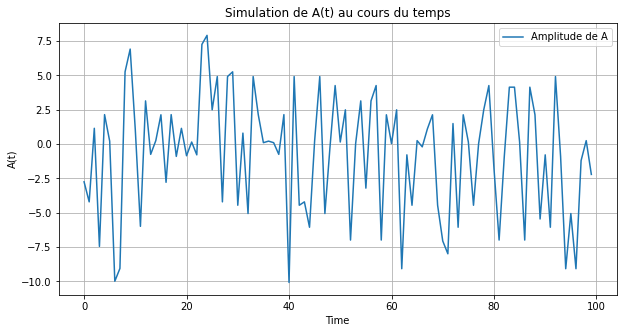

In [ ]:
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

In [216]:
# Let's try to simulate the explosion of A(t)
T = 100      # Time horizon
Ns = 1000       # Number of speculators

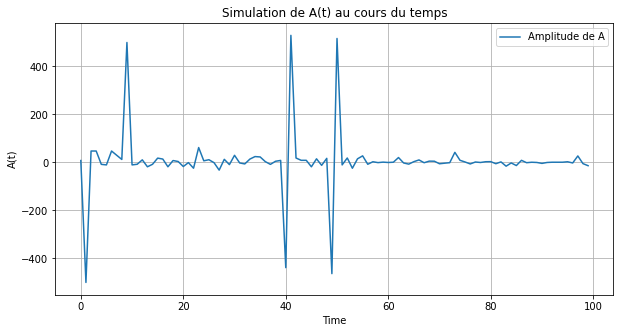

In [ ]:
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

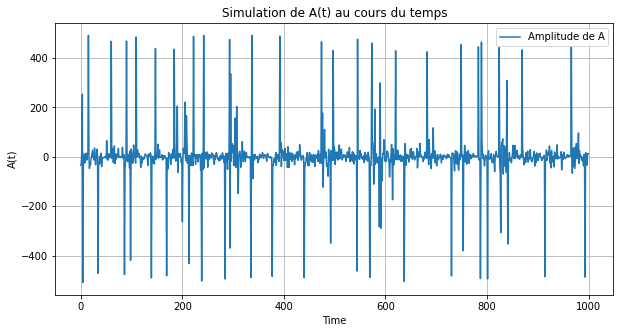

In [ ]:
T = 1000
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

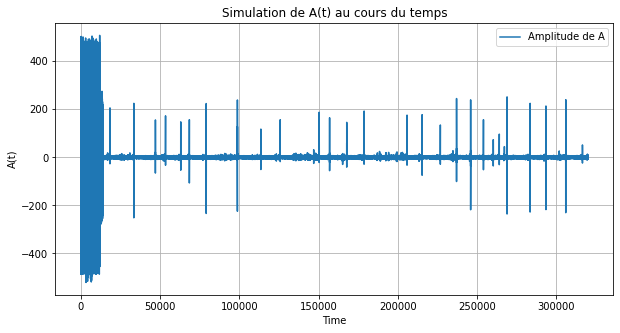

In [ ]:
T = int(200*P/epsilon)
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

3. mesurer les fluctuations $\sigma^2 = <A^2>$ et la prévisibilité $H_0 = \sum_{\mu} \frac{<A|\mu>^2}{P}$. Tracer $\frac{\sigma^2}{P}$ et $H_0/P$ en fonction de ns = Ns/P en fixant P et en faisant varier Ns (10-15 points suffisent). La moyenne est prise sur plusieurs réalisations du jeu pour chaque jeu de paramètres ;

In [220]:
T = 100      # Time horizon
Ns = 10       # Number of speculators
P = 16          # Number of possible information states mu as P in [10,20] and needs to be a power of 2
Np = 16         # Number of producers (variance for Omega)
epsilon = 0.01  # Minimum performance to keep participating
M = 3           # Memory length (number of signs of A(t) to encode mu)

In [293]:
def compute_sigma_2(initialization, Ns, P, Np, M, T, epsilon):
    A_history, mu_history, performance = simulation(initialization, Ns, P, Np, M, T, epsilon)
    # If we understand it as the quadratic variation of A(t) :
    # sigma2 = 0
    # for i in range(len(A_history)-1):
    #    sigma2 += (A_history[i+1] - A_history[i])**2
    # Else, we can see it as the mean of the square of A(t) as sigma^2 can be seen as the variance of A(t) and the mean of A(t) is really close to 0 as demonstrated in the next cell.
    sigma2 = np.mean([A**2 for A in A_history])
    return sigma2

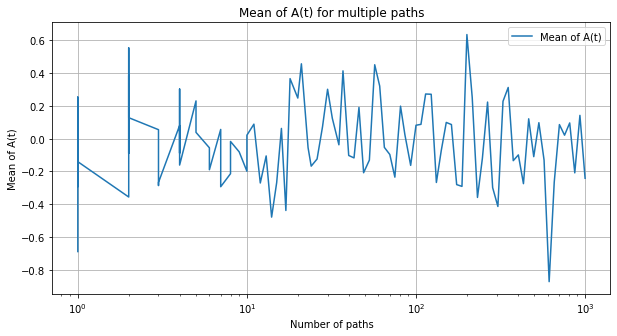

In [ ]:
# We show that the average mean of A(t) is close to 0 for multiple simulations. 
Ns = 100
num_paths = np.logspace(0, 3, 100).astype(int) 
A_history_mean = []
for num in num_paths:
    for _ in range(num):
        inter = []
        A_history, mu_history, performance = simulation(initialize, Ns, P, Np, M, T, epsilon)
        inter.append(np.mean(A_history))
    A_history_mean.append(np.mean(inter))
plt.figure(figsize=(10, 5))
plt.plot(num_paths, A_history_mean, label=f'Mean of A(t)')
plt.xlabel('Number of paths')
plt.ylabel('Mean of A(t)')
plt.xscale('log')
plt.title('Mean of A(t) for multiple paths')
plt.legend()
plt.grid()
plt.show()

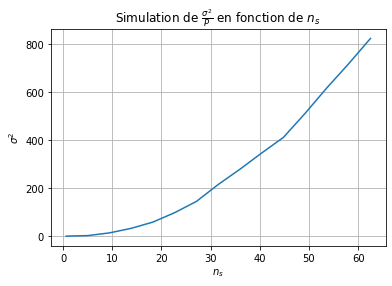

In [ ]:
Ns = np.linspace(10, 1000, 15).astype(int)  
num_iterations = 100
sigma2 = [np.mean([compute_sigma_2(initialize, n, P, Np, M, T, epsilon) for _ in range(num_iterations)])/P for n in Ns]
plt.plot(Ns/P, sigma2)
plt.xlabel('$n_s$')
plt.ylabel('$\\frac{\sigma^2}{P}$')  
plt.title('Simulation de $\\frac{\sigma^2}{P}$ en fonction de $n_s$')
plt.grid()
plt.show()

In [297]:
def previsibilite(initialization, Ns, P, Np, M, T, epsilon):
    A_history, mu_history, performance = simulation(initialization, Ns, P, Np, M, T, epsilon)
    A_mu_mean = np.zeros(P)
    count_mu = np.zeros(P)

    for t in range(len(A_history)):
        mu = mu_history[t]
        A_mu_mean[mu] += A_history[t]
        count_mu[mu] += 1

    valid_indices = count_mu > 0
    A_mu_mean[valid_indices] /= count_mu[valid_indices]    
    H_0 = np.sum(A_mu_mean**2) / P
    return H_0

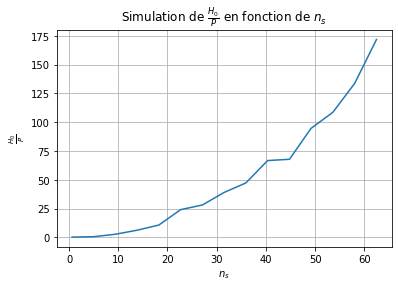

In [ ]:
Ns = np.linspace(10, 1000, 15).astype(int)
num_iterations = 100
H_0 = [np.mean([previsibilite(initialize, n, P, Np, M, T, epsilon) for _ in range(num_iterations)])/P for n in Ns]
plt.plot(Ns/P, H_0)
plt.xlabel('$n_s$')
plt.ylabel('$\\frac{H_0}{P}$')  
plt.title('Simulation de $\\frac{H_0}{P}$ en fonction de $n_s$')
plt.grid()
plt.show()

4. vérifier que $H_0 = 0$ n'est pas possible si $\epsilon > 0$.

In [298]:
def explore_H0_with_epsilon(initialization, Ns, P, Np, M, T, epsilon_values, num_iterations):
    H_0_values = []
    for epsilon in epsilon_values:
        H_0 = np.mean([previsibilite(initialization, Ns, P, Np, M, T, epsilon) for _ in range(num_iterations)]) / P
        H_0_values.append(H_0)
    return H_0_values

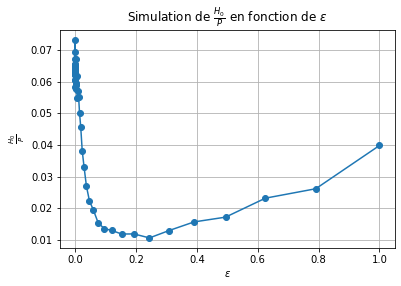

In [ ]:
epsilon_values = np.logspace(-5, 0, 50) 
Ns = 100
T = 1000
H_0_values = explore_H0_with_epsilon(initialize, Ns, P, Np, M, T, epsilon_values, num_iterations)

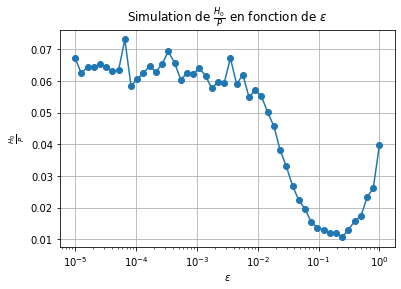

In [279]:
plt.plot(epsilon_values, H_0_values, marker='o')
plt.xlabel('$\epsilon$')
plt.ylabel('$\\frac{H_0}{P}$')
plt.title('Simulation de $\\frac{H_0}{P}$ en fonction de $\epsilon$')
plt.xscale('log')
plt.grid()
plt.show()

5. prendre $a_{i,μ} \sim P(a)$ où $P(a)$ est telle que $E(a) = 0$ et $E(a^2) = 1$. Y-a-t'il des différences perceptibles ?

Nous devons donc implémenter les stratégies des agents $a_{i,\mu}$ telles qu'elles suivent une distribution $P(a)$ avec une espérance nulle et une variance unité.

In [280]:
# We are going to initialize strategies

def initialize_normal(Ns, P, Np):

    # We initialize the agents with a normal law this time.
    strategies = np.random.normal(0, 1, size=(Ns, P))
    performance = np.zeros(Ns)
    
    # We initialize omega and mu
    Omega = np.random.normal(0, np.sqrt(Np), size=P)
    # We want to generate a number between 0 and P-1 included
    mu = np.random.randint(0, P)

    return strategies, performance, Omega, mu

In [281]:
# Let's define the parameters of the game 
T = 100      # Time horizon
Ns = 10       # Number of speculators
P = 16          # Number of possible information states mu as P in [10,20] and needs to be a power of 2
Np = 16         # Number of producers (variance for Omega)
epsilon = 0.01  # Minimum performance to keep participating
M = 3           # Memory length (number of signs of A(t) to encode mu)

In [288]:
# We are going to display A_history which is a time series of global actions A(t), mu_history as the sequence of encoded market states μ and the top performing agents. 
A_history, mu_history, performance = simulation(initialize_normal, Ns, P, Np, M, T, epsilon)
print("Final mu:", mu_history[-1])
print("Final A(t):", A_history[-1])
print("Top 5 performing agents:", np.argsort(performance)[-5:])

Final mu: 7
Final A(t): -0.00823085899678988
Top 5 performing agents: [6 3 0 7 1]


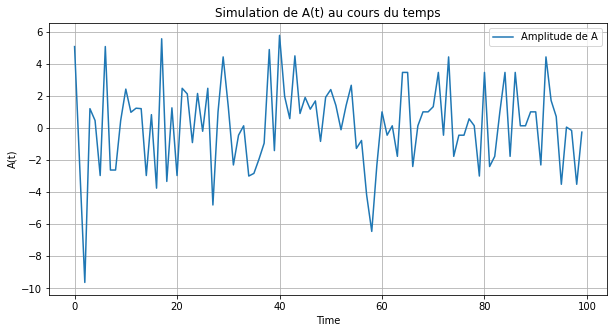

In [289]:
plot_simulation(initialize_normal, Ns, P, Np, M, T, epsilon)

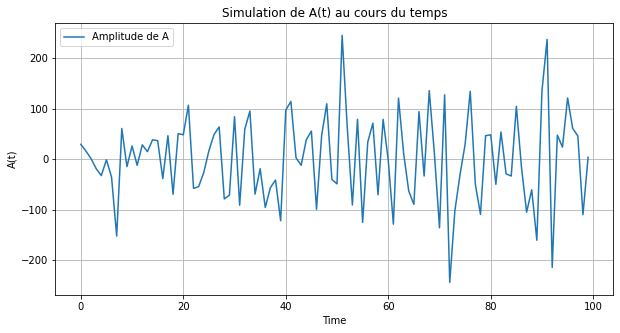

In [290]:
T = 100 
Ns = 1000
plot_simulation(initialize_normal, Ns, P, Np, M, T, epsilon)

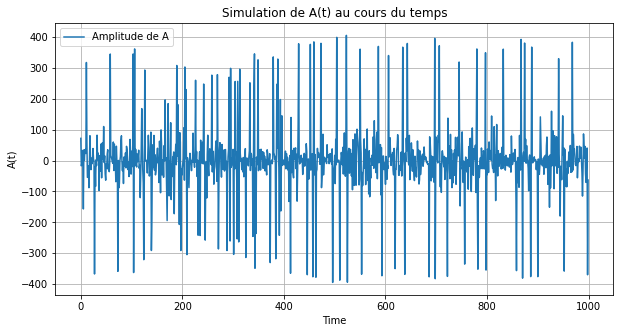

In [291]:
T = 1000
plot_simulation(initialize_normal, Ns, P, Np, M, T, epsilon)

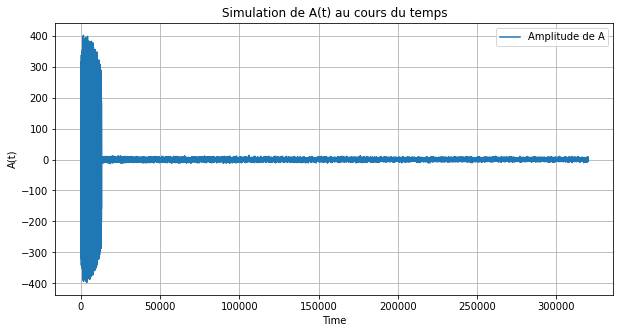

In [292]:
T = int(200*P/epsilon)
plot_simulation(initialize_normal, Ns, P, Np, M, T, epsilon)

In [294]:
# Let's define the parameters of the game 
T = 100      # Time horizon
Ns = 10       # Number of speculators
P = 16          # Number of possible information states mu as P in [10,20] and needs to be a power of 2
Np = 16         # Number of producers (variance for Omega)
epsilon = 0.01  # Minimum performance to keep participating
M = 3           # Memory length (number of signs of A(t) to encode mu)

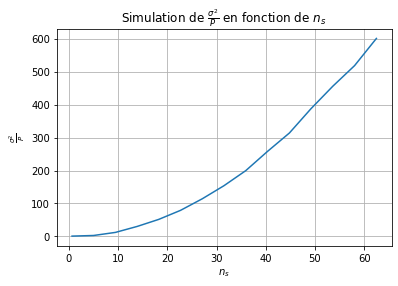

In [296]:
Ns = np.linspace(10, 1000, 15).astype(int)  
num_iterations = 100
sigma2 = [np.mean([compute_sigma_2(initialize_normal, n, P, Np, M, T, epsilon) for _ in range(num_iterations)])/P for n in Ns]
plt.plot(Ns/P, sigma2)
plt.xlabel('$n_s$')
plt.ylabel('$\\frac{\sigma^2}{P}$')  
plt.title('Simulation de $\\frac{\sigma^2}{P}$ en fonction de $n_s$')
plt.grid()
plt.show()

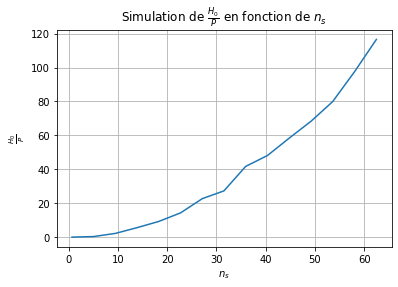

In [299]:
Ns = np.linspace(10, 1000, 15).astype(int)
num_iterations = 100
H_0 = [np.mean([previsibilite(initialize_normal, n, P, Np, M, T, epsilon) for _ in range(num_iterations)])/P for n in Ns]
plt.plot(Ns/P, H_0)
plt.xlabel('$n_s$')
plt.ylabel('$\\frac{H_0}{P}$')  
plt.title('Simulation de $\\frac{H_0}{P}$ en fonction de $n_s$')
plt.grid()
plt.show()

In [300]:
epsilon_values = np.logspace(-5, 0, 50) 
Ns = 100
T = 1000
H_0_values = explore_H0_with_epsilon(initialize_normal, Ns, P, Np, M, T, epsilon_values, num_iterations)

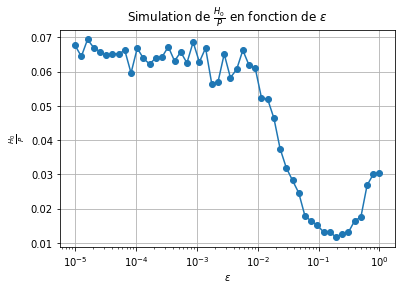

In [301]:
plt.plot(epsilon_values, H_0_values, marker='o')
plt.xlabel('$\epsilon$')
plt.ylabel('$\\frac{H_0}{P}$')
plt.title('Simulation de $\\frac{H_0}{P}$ en fonction de $\epsilon$')
plt.xscale('log')
plt.grid()
plt.show()